In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pymc as pm
import multiprocessing
import arviz as az
import warnings
import sys

sys.path.append(os.path.abspath(os.path.join("../")))

from src.evaluate import ams_score, report_metrics

# --- Reproducibility setup ---
SEED = 1

np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
pm.set_data = getattr(pm, "set_data", lambda *args, **kwargs: None)

# --- Warning filters ---
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Split into training and test sets

In [71]:
#Load preprocessed data
df = pd.read_csv("../data/processed/df_preprocessed.csv", index_col=0)
weights =  pd.read_csv("../data/processed/weights.csv", index_col=0)
df['Weight'] = weights

data_train, data_test = train_test_split(df, test_size=0.2, random_state=42)
weights_train = data_train["Weight"]
weights_test = data_test["Weight"]
X_train = data_train.drop(["Weight", "Label"], axis=1)
X_test = data_test.drop(["Weight", "Label"], axis=1)
y_train = data_train["Label"]
y_test = data_test["Label"]

# Bayesian logistic regression model

**Model specifics and theoretical justification**

We model $y_i \sim \text{Bernoulli}(\sigma(X_i \beta + \alpha))$ where:

- $X_i$ are standardized features.
- Priors: $\beta_j \sim \mathcal{N}(0,\, 2.5)$.  
  *Rationale:* weakly informative prior recommended for logistic regression (reduces extreme posterior wandering, regularizes coefficients).
- Intercept: $\alpha \sim \mathcal{N}(0,\, 5)$.
- We use NUTS for sampling; inference produces posterior samples for every coefficient.


In [ ]:
# If dataset is huge, MCMC may be slow. We'll sample a reasonable subset, preserving class balance.
max_train_samples = 100000
feature_names = list(X_train.columns)

if X_train.shape[0] > max_train_samples:
    # stratified sampling
    train_df = X_train.copy()
    train_df["y"] = y_train
    train_small = train_df.groupby("y").sample(n=int(max_train_samples / 2), random_state=42)
    X_bayes = train_small[feature_names].values
    y_bayes = train_small["y"].values
    print("Using subsample for MCMC:", X_bayes.shape)
else:
    X_bayes = X_train.values
    y_bayes = y_train.values
    print("Using full training set for MCMC:", X_bayes.shape)

Using subsample for MCMC: (1000, 17)


In [74]:
# Build and run PyMC model (computationaly expensive, just load the results from the cell below)
y_bayes_num = np.where(y_bayes == "s", 1, 0).astype(int)
n_features = X_train.shape[1]

with pm.Model() as logistic_model:
    # Priors
    alpha = pm.Normal("alpha", mu=0.0, sigma=5.0)
    beta = pm.Normal("beta", mu=0.0, sigma=2.5, shape=n_features)

    # Linear predictor (dot product)
    # convert X to shared variable for possible re-use -> but simple approach now
    mu = alpha + pm.math.dot(X_bayes, beta)

    # Likelihood
    theta = pm.math.sigmoid(mu)
    y_obs = pm.Bernoulli("y_obs", p=theta, observed=y_bayes_num)

    # Sample with NUTS
    trace = pm.sample(
        draws=2000,
        tune=1500,
        chains=2,
        progressbar=True,
        cores=multiprocessing.cpu_count(),
        target_accept=0.9,
        return_inferencedata=True,
    )

    # Save the model
    az.to_netcdf(trace, "models/bayesian_logreg_trace.nc")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]


Output()

Sampling 2 chains for 1_500 tune and 1_565 draw iterations (3_000 + 3_130 draws total) took 110 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


FileNotFoundError: [Errno 2] Unable to synchronously create file (unable to open file: name = 'c:\Users\Daniel\Desktop\AML\Labs\MDS-AML-HiggsBosonATLAS\notebooks\models\bayesian_logreg_trace.nc', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

In [76]:
# Load the model
trace = az.from_netcdf("../models/bayesian_logreg_trace.nc")

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.439,0.012,0.416,0.463,0.0,0.0,2738.0,2809.0,1.0
beta[0],-0.862,0.018,-0.894,-0.826,0.0,0.0,2540.0,2684.0,1.0
beta[1],-0.675,0.009,-0.695,-0.657,0.0,0.0,5619.0,2170.0,1.0
beta[2],0.255,0.013,0.229,0.282,0.0,0.0,2648.0,3042.0,1.0
beta[3],1.093,0.018,1.056,1.128,0.0,0.0,2548.0,2957.0,1.0
beta[4],-0.225,0.008,-0.241,-0.210,0.0,0.0,5080.0,2918.0,1.0
beta[5],-0.278,0.017,-0.312,-0.245,0.0,0.0,2671.0,2731.0,1.0
beta[6],0.300,0.017,0.265,0.332,0.0,0.0,2207.0,2512.0,1.0
beta[7],0.324,0.010,0.304,0.343,0.0,0.0,4150.0,3182.0,1.0
beta[8],1.420,0.020,1.383,1.461,0.0,0.0,1938.0,2422.0,1.0


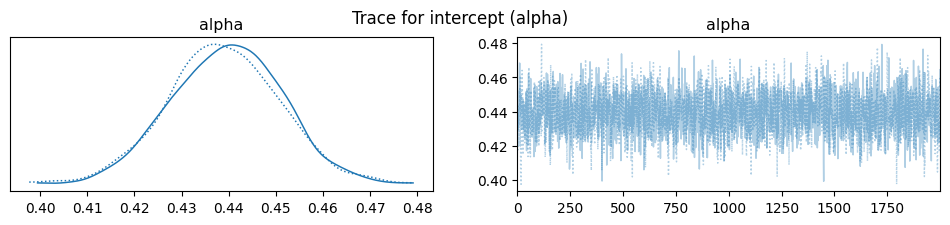

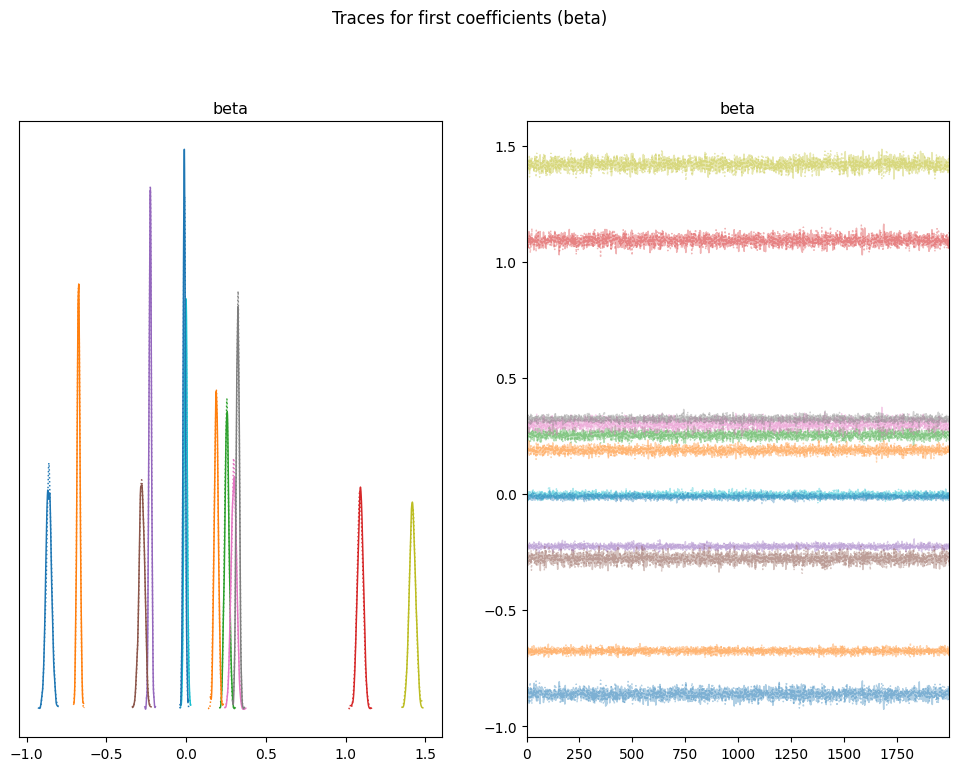

In [77]:
# Diagnostics: traceplot and posterior summary
az.plot_trace(trace, var_names=["alpha"])
plt.suptitle("Trace for intercept (alpha)", y=1.02)

# Plot several coefficient traces (first 12 coefficients for readability)
subset_beta_idx = list(range(min(12, n_features)))
az.plot_trace(trace, var_names=["beta"], coords={"beta_dim_0": subset_beta_idx}, figsize=(12, 8))
plt.suptitle("Traces for first coefficients (beta)", y=1.02)

# Posterior summary numeric
summary_df = az.summary(trace, var_names=["alpha", "beta"], hdi_prob=0.95)
display(summary_df)

## Posterior predictive checks & predictive performance

We approximate predictive probabilities on the test set using posterior samples:
- use posterior samples of `alpha` and `beta` to compute predictive probabilities for each test point (posterior predictive mean)
- compute ROC AUC from posterior predictive mean
- compare with baseline logistic regression

In [79]:
# Posterior predictive probabilities on test set (approximate with Monte Carlo)
# Get posterior samples arrays
posterior = trace.posterior
beta_samples = posterior["beta"].stack(sample=("chain", "draw")).values
alpha_samples = posterior["alpha"].stack(sample=("chain", "draw")).values.flatten()
beta_all = beta_samples
alpha_all = alpha_samples

# Use all posterior samples for predictions (may be large)
n_post_samples = beta_all.shape[1]
print("Posterior draws available:", n_post_samples)

# Convert X_test to numpy
X_test_np = X_test.values if isinstance(X_test, pd.DataFrame) else X_test


# compute p(y=1 | x, posterior) approximated by sigmoid(alpha_s + x @ beta_s) averaged over posterior draws
# we vectorize in chunks to avoid memory spikes
def posterior_predictive_proba(X, alpha_samps, beta_samps, chunk=1000):
    n_samples = beta_samps.shape[1]
    probs_accum = np.zeros((X.shape[0],))
    # iterate over posterior draws in chunks
    for i in range(0, n_samples, chunk):
        b = beta_samps[:, i : i + chunk]
        a = alpha_samps[i : i + chunk]
        # compute linear predictors for chunk: X @ b
        lin = X @ b
        lin = lin + a  # broadcasts
        probs_chunk = 1 / (1 + np.exp(-lin))
        probs_accum += probs_chunk.mean(axis=1) * (chunk / n_samples)
    return probs_accum


# safe chunking: choose chunk size so we exactly weight average
posterior_mean_proba = posterior_predictive_proba(X_test_np, alpha_all, beta_all, chunk=200)

auc_bayes = roc_auc_score(y_test, posterior_mean_proba)
print(f"Bayesian logistic (posterior mean predictive) AUC: {auc_bayes:.4f}")

# Threshold posterior mean probability at 0.5
y_pred_bayes = (posterior_mean_proba >= 0.5).astype(int)

# Ensure true labels
y_test_num = np.where(y_test == "s", 1, 0).astype(int)

# Accuracy
acc_bayes = accuracy_score(y_test_num, y_pred_bayes)
print(f"Bayesian Logistic Regression Accuracy: {acc_bayes:.4f}")

# Classification report
print("Bayesian Logistic Regression Classification Report:")
print(classification_report(y_test_num, y_pred_bayes, target_names=["b", "s"]))

Posterior draws available: 4000
Bayesian logistic (posterior mean predictive) AUC: 0.7655
Bayesian Logistic Regression Accuracy: 0.6603
Bayesian Logistic Regression Classification Report:
              precision    recall  f1-score   support

           b       0.85      0.54      0.66     84515
           s       0.54      0.85      0.66     54213

    accuracy                           0.66    138728
   macro avg       0.70      0.69      0.66    138728
weighted avg       0.73      0.66      0.66    138728



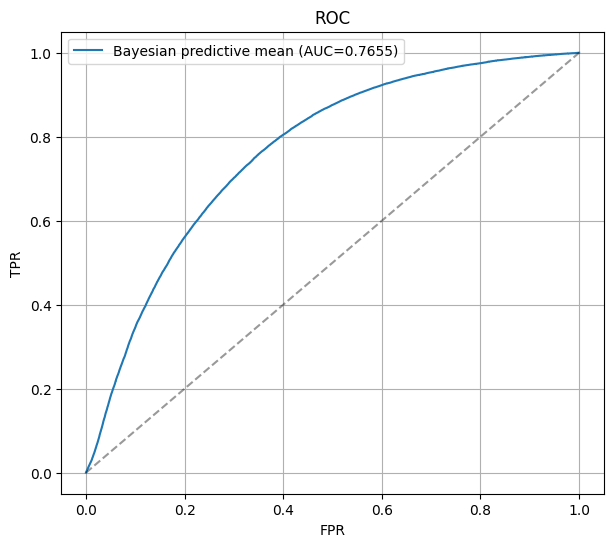

In [80]:
# ROC curve
fpr_b, tpr_b, _ = roc_curve(y_test, posterior_mean_proba, pos_label="s")

plt.figure(figsize=(7, 6))
plt.plot(fpr_b, tpr_b, label=f"Bayesian predictive mean (AUC={auc_bayes:.4f})")
plt.plot([0, 1], [0, 1], "k--", alpha=0.4)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()
plt.grid(True)